### INTRODUCTION

In this notebook we have performed an analysis of energy consumption and revenue data spanning residential, commercial, and industrial sectors. Our focused objectives are to:

i) Determine the impact of peak energy demand on revenues.

ii) Identify seasonal consumption patterns.

iii)Uncover revenue drivers across customer segments.


Commencing with data cleansing to ensure data quality, we'll proceed with exploratory data analysis for initial insights, followed by predictive modeling to inform strategic decision-making. 
We will employ linear regression to quantify the impact of peak energy demand on revenue and utilize KMeans clustering to uncover seasonal consumption trends and identify revenue drivers across customer segments. This  analysis is performed to inform strategic decision-making and foster operational optimization within the utility sector.

### LOAD DATASET AND LIBRARIES

In [2]:
#Read data and load libraries

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier


path = 'Elecricity_Cleaned.csv'
data = pd.read_csv(path)
data.head()

,Utility.Number,Utility.Name,Utility.State,Utility.Type,Demand.Summer Peak,Demand.Winter Peak,Sources.Generation,Sources.Purchased,Sources.Other,Sources.Total,...,Retail.Commercial.Customers,Retail.Industrial.Revenue,Retail.Industrial.Sales,Retail.Industrial.Customers,Retail.Transportation.Revenue,Retail.Transportation.Sales,Retail.Transportation.Customers,Retail.Total.Revenue,Retail.Total.Sales,Retail.Total.Customers
0,34,City of Abbeville - (SC),SC,Municipal,13.7,10.8,7000.0,59000.0,0.0,66000.0,...,460.0,0.0,0.0,0.0,0.0,0.0,0.0,7536.0,58000.0,3844.0
1,55,City of Aberdeen - (MS),MS,Municipal,32.4,30.3,0.0,209454.0,0.0,209454.0,...,662.0,5638.0,120537.0,1.0,0.0,0.0,0.0,14797.0,204261.0,3229.0
2,59,City of Abbeville - (LA),LA,Municipal,28.9,22.0,0.0,137264.0,0.0,137264.0,...,887.0,3011.1,35881.0,27.0,0.0,0.0,0.0,12383.0,127579.0,5494.0
3,84,A & N Electric Coop,VA,Cooperative,154.0,162.4,596.0,743457.0,0.0,744053.0,...,4227.0,15516.0,176162.0,8.0,0.0,0.0,0.0,78507.0,704010.0,35934.0
4,87,City of Ada - (MN),MN,Municipal,2.1,2.2,0.0,20028.0,0.0,20028.0,...,255.0,190.0,2615.0,58.0,0.0,0.0,0.0,1593.0,20028.0,1185.0


In [3]:
# Display the column names
print(data.columns.tolist())

['Utility.Number', 'Utility.Name', 'Utility.State', 'Utility.Type', 'Demand.Summer Peak', 'Demand.Winter Peak', 'Sources.Generation', 'Sources.Purchased', 'Sources.Other', 'Sources.Total', 'Uses.Retail', 'Uses.Resale', 'Uses.No Charge', 'Uses.Consumed', 'Uses.Losses', 'Uses.Total', 'Revenues.Retail', 'Revenue.Delivery', 'Revenue.Resale', 'Revenue.Adjustments', 'Revenue.Transmission', 'Revenue.Other', 'Revenue.Total', 'Retail.Residential.Revenue', 'Retail.Residential.Sales', 'Retail.Residential.Customers', 'Retail.Commercial.Revenue', 'Retail.Commercial.Sales', 'Retail.Commercial.Customers', 'Retail.Industrial.Revenue', 'Retail.Industrial.Sales', 'Retail.Industrial.Customers', 'Retail.Transportation.Revenue', 'Retail.Transportation.Sales', 'Retail.Transportation.Customers', 'Retail.Total.Revenue', 'Retail.Total.Sales', 'Retail.Total.Customers']


### DATA CLEANING

In [4]:
# Check for missing values
print(data.isnull().sum())

Utility.Number                     0
Utility.Name                       0
Utility.State                      0
Utility.Type                       0
Demand.Summer Peak                 0
Demand.Winter Peak                 0
Sources.Generation                 0
Sources.Purchased                  0
Sources.Other                      0
Sources.Total                      0
Uses.Retail                        0
Uses.Resale                        0
Uses.No Charge                     0
Uses.Consumed                      0
Uses.Losses                        0
Uses.Total                         0
Revenues.Retail                    0
Revenue.Delivery                   0
Revenue.Resale                     0
Revenue.Adjustments                0
Revenue.Transmission               0
Revenue.Other                      0
Revenue.Total                      0
Retail.Residential.Revenue         0
Retail.Residential.Sales           0
Retail.Residential.Customers       0
Retail.Commercial.Revenue          0
R

In [5]:
#Remove the missing value row
data = data.dropna(subset=['Utility.State'])

In [6]:
#Calculate summary statistics for all columns
summary_statistics = data.describe()

# Print the summary statistics
print(summary_statistics)

       Utility.Number  Demand.Summer Peak  Demand.Winter Peak  \
count     3173.000000         3173.000000         3173.000000   
mean     16285.686101          268.350930          235.715916   
std      15761.920643         1373.522557         1212.759117   
min         34.000000            0.000000            0.000000   
25%       6276.000000            4.000000            3.500000   
50%      12796.000000           20.600000           18.500000   
75%      18330.000000           80.200000           75.100000   
max      63546.000000        29569.000000        27796.000000   

       Sources.Generation  Sources.Purchased  Sources.Other  Sources.Total  \
count        3.173000e+03       3.173000e+03   3.173000e+03   3.173000e+03   
mean         7.001795e+05       1.121634e+06   7.140313e+03   1.828953e+06   
std          6.536037e+06       8.605797e+06   3.092089e+05   1.233348e+07   
min         -5.174000e+04       0.000000e+00  -1.239123e+06   0.000000e+00   
25%          0.000000e+0

## EXPLORATORY DATA ANALYSIS AND VISUALIZATION

##### Identifying outliers using boxplot

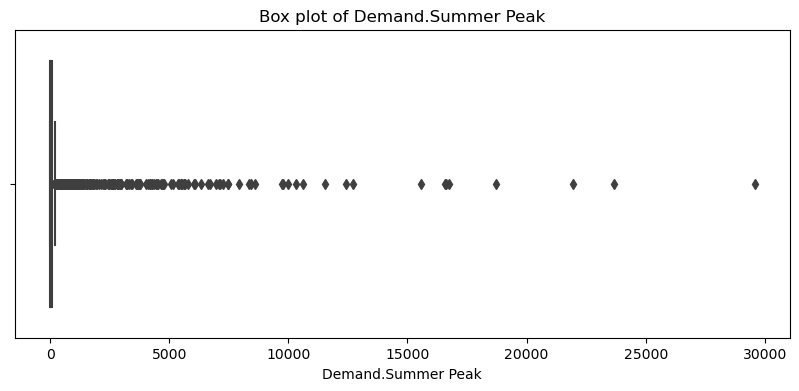

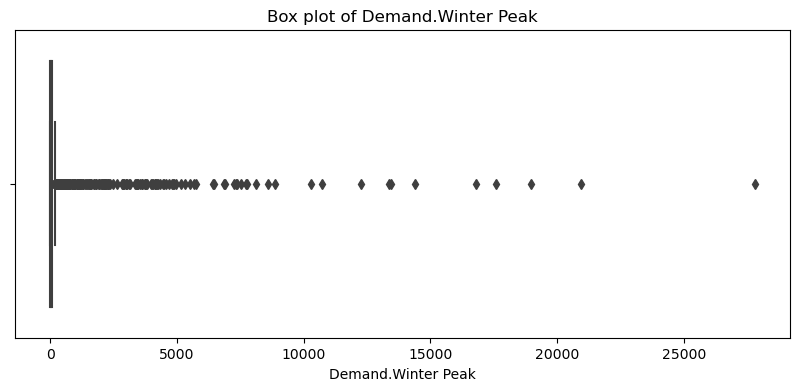

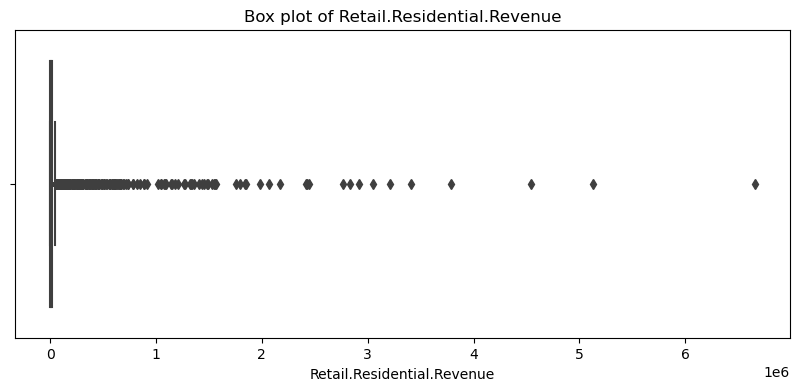

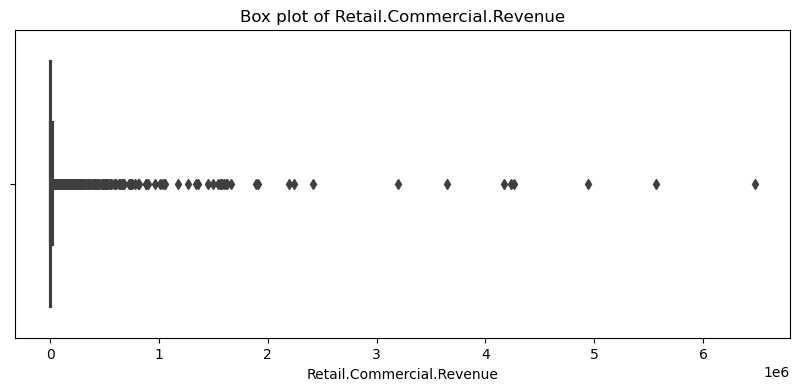

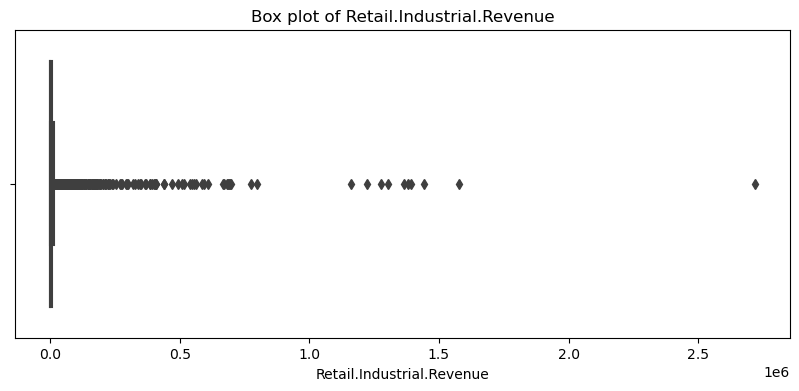

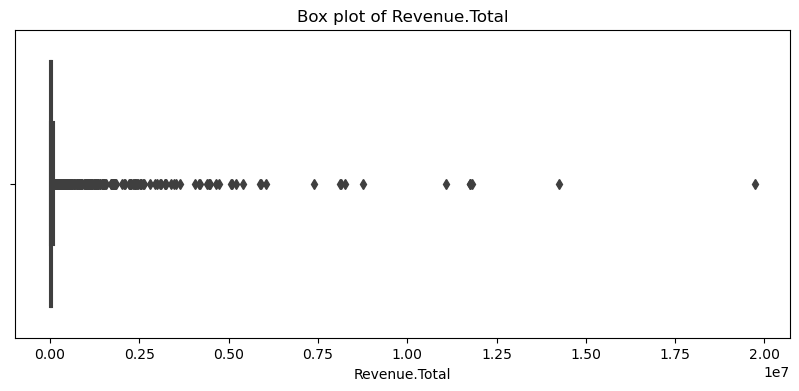

In [7]:

# List of significant attributes
key_columns = [
    'Demand.Summer Peak',
    'Demand.Winter Peak',
    'Retail.Residential.Revenue',
    'Retail.Commercial.Revenue',
    'Retail.Industrial.Revenue',
    'Revenue.Total'
]

# Create a box plot for attributes
for col in key_columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=data[col])
    plt.title(f'Box plot of {col}')
    plt.show()

##### Selecting Key attributes for correlation analysis

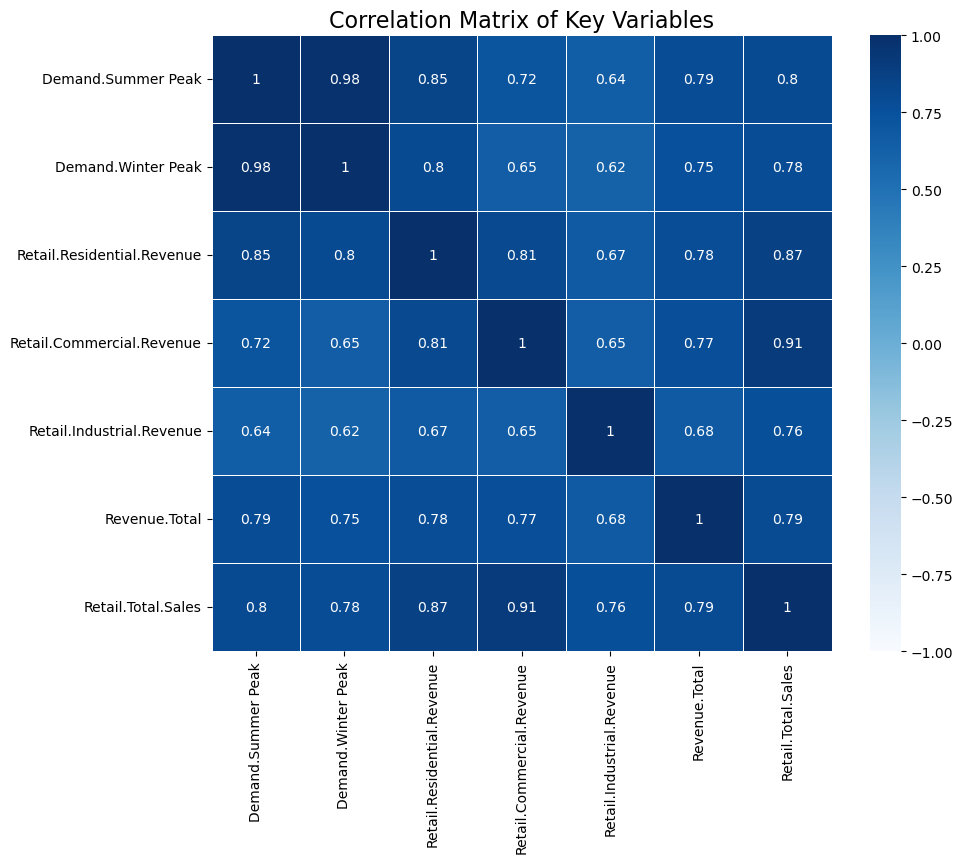

In [9]:
columns_to_plot = [
    'Demand.Summer Peak',
    'Demand.Winter Peak',
    'Retail.Residential.Revenue',
    'Retail.Commercial.Revenue',
    'Retail.Industrial.Revenue',
    'Revenue.Total',
    'Retail.Total.Sales'
]

# Compute the correlation matrix
correlation_matrix = data[columns_to_plot].corr()


# Plot the heatmap with blue color theme and white annotations
plt.figure(figsize=(10, 8))  # Adjusted size for better aspect
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1, annot_kws={"color": "white"}, linewidths=.5)
plt.title('Correlation Matrix of Key Variables', fontsize=16)
plt.show()

## PREDICTIVE ANALYSIS AND MODELING

### 1.How Does Peak Energy Demand Impact Total Utility Revenue?(Used Linear Regression)

In [56]:

#Remove outliers using Interquartile Range (IQR):
Q1 = data.quantile(0.25, numeric_only=True)
Q3 = data.quantile(0.75, numeric_only=True)
IQR = Q3 - Q1

# Define outliers as those outside of Q1 - 1.5*IQR and Q3 + 1.5*IQR
# Align the DataFrame and Series for comparison
data_aligned, Q1_aligned = data.align(Q1, axis=1)
data_aligned, Q3_aligned = data.align(Q3, axis=1)

outliers = (data_aligned < (Q1_aligned - 1.5 * IQR)) | (data_aligned > (Q3_aligned + 1.5 * IQR))

# Remove outliers
data_no_outliers = data[~outliers.any(axis=1)]

#Define predictor variables and the response variable:
X = data_no_outliers[['Demand.Summer Peak', 'Demand.Winter Peak']]
y = data_no_outliers['Revenue.Total']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model on the training data
model = LinearRegression().fit(X_train, y_train)

#Evaluate the model on both the training and testing data:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f'Train R-squared: {train_score}')
print(f'Test R-squared: {test_score}')

#Print model coefficients and intercept
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')

Train R-squared: 0.9443964468194563
Test R-squared: 0.9647358316686916
Coefficients: [286.65134075 218.71307213]
Intercept: 258.5284465151308


The positive coefficients for both 'Demand.Summer Peak' and 'Demand.Winter Peak' imply that increases in energy usage during these peak times are associated with proportional increases in revenue. This can inform the utility company's strategies for capacity planning, pricing models, and demand response programs.

For example, during anticipated peak periods, the company might consider implementing dynamic pricing to manage the demand or invest in marketing programs aimed at maximizing the revenue potential during these high-demand seasons. Additionally, this model could assist in financial forecasting, allowing the company to make more accurate predictions about future revenues based on expected demand patterns.

The results underscore the importance of effective demand management and the potential financial benefits of ensuring the utility has sufficient capacity to meet peak demands.

In [57]:
# Predict on the training and testing data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Comparing actual and predicted values, for example, on the test set
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
comparison_df['Difference'] = comparison_df['Actual'] - comparison_df['Predicted']

# Display the first few rows to see the actual vs predicted values
print(comparison_df.head())

       Actual     Predicted   Difference
2605   6195.0   6706.156144  -511.156144
1710  36018.0  39763.900237 -3745.900237
1933  12039.6  12705.749698  -666.149698
1398   9388.0   6572.603954  2815.396046
954    1575.2   1665.265149   -90.065149


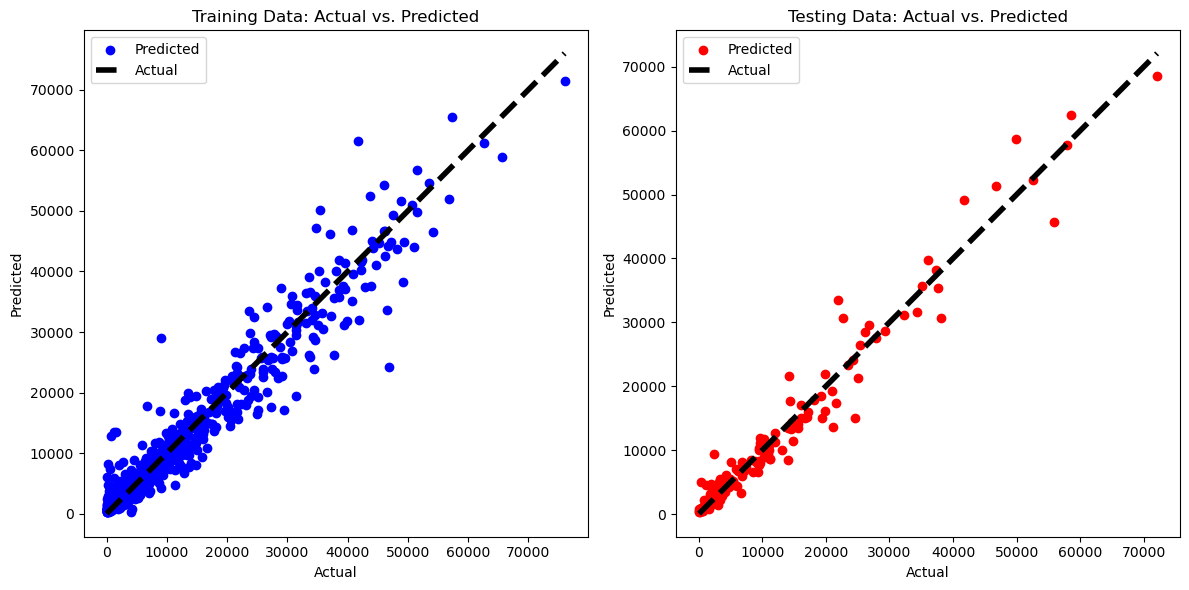

In [58]:

# Plot for training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, c='blue', label='Predicted')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'k--', lw=4, label='Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Data: Actual vs. Predicted')
plt.legend()

# Plot for testing data
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, c='red', label='Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=4, label='Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Testing Data: Actual vs. Predicted')
plt.legend()

plt.tight_layout()
plt.show()


##### Visualization of model's performance

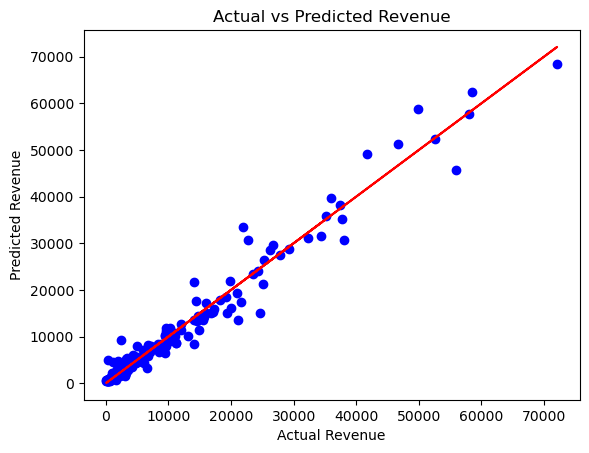

In [59]:
plt.scatter(y_test, y_test_pred, color='blue')
plt.plot(y_test, y_test, color='red')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted Revenue')
plt.show()


##### Winter and Summer Peak Demand vs Revenue

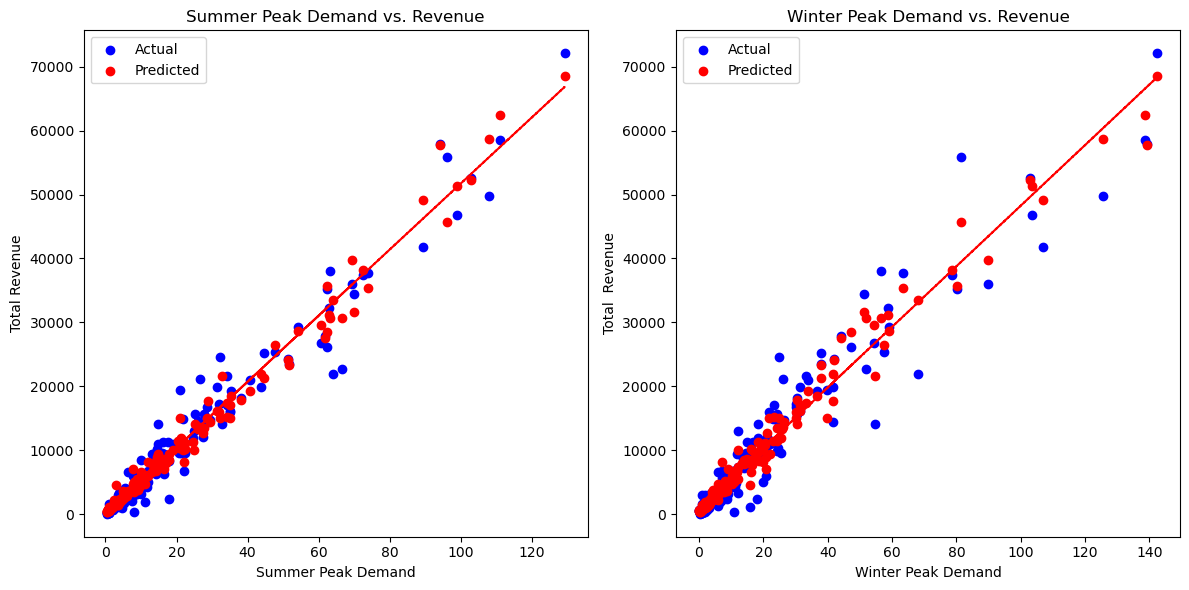

In [60]:
# Predict on the training and testing data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Extract summer and winter data
summer_demand_actual = X_test['Demand.Summer Peak']
winter_demand_actual = X_test['Demand.Winter Peak']

# Create subplots for summer peak demand
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(summer_demand_actual, y_test, c='blue', label='Actual')
plt.scatter(summer_demand_actual, y_test_pred, c='red', label='Predicted')
plt.xlabel('Summer Peak Demand')
plt.ylabel('Total Revenue')
plt.title('Summer Peak Demand vs. Revenue')
plt.legend()

# Create regression line for summer peak demand
summer_regression_line = np.polyfit(summer_demand_actual, y_test_pred, 1)
plt.plot(summer_demand_actual, np.polyval(summer_regression_line, summer_demand_actual), 'r--', label='Regression Line')

# Create subplots for winter peak demand
plt.subplot(1, 2, 2)
plt.scatter(winter_demand_actual, y_test, c='blue', label='Actual')
plt.scatter(winter_demand_actual, y_test_pred, c='red', label='Predicted')
plt.xlabel('Winter Peak Demand')
plt.ylabel('Total  Revenue')
plt.title('Winter Peak Demand vs. Revenue')
plt.legend()

# Create regression line for winter peak demand
winter_regression_line = np.polyfit(winter_demand_actual, y_test_pred, 1)
plt.plot(winter_demand_actual, np.polyval(winter_regression_line, winter_demand_actual), 'r--', label='Regression Line')

plt.tight_layout()
plt.show()

Seasonal Revenue Patterns: The data points (blue) scattered over the graph show that when power demand rises during summer and winter peaks, the company's income rises as well, implying a direct and positive link between electricity demand and revenue.

These insights can be used to make informed decisions on capacity planning, pricing strategies, and demand response initiatives. For example, during predicted high-demand periods, the company could adjust pricing to manage the load and maximize revenue.

The analysis might also assist in directing infrastructure investment to ensure stability during high demand periods, which are critical for maintaining and generating revenue.

##### Residual Plots

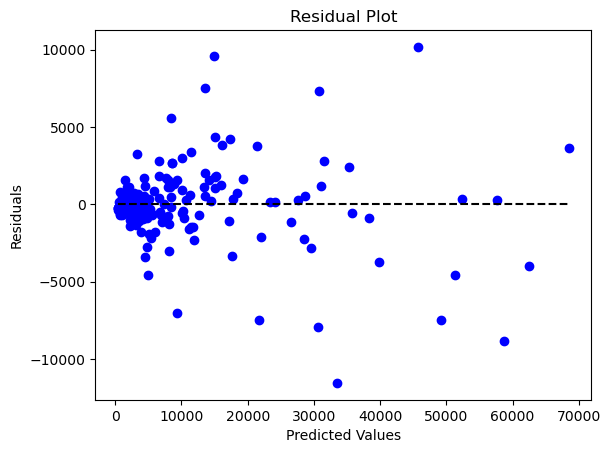

In [61]:
residuals = y_test - y_test_pred

plt.scatter(y_test_pred, residuals, color='blue')
plt.hlines(y=0, xmin=y_test_pred.min(), xmax=y_test_pred.max(), colors='black', linestyles='dashed')

plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

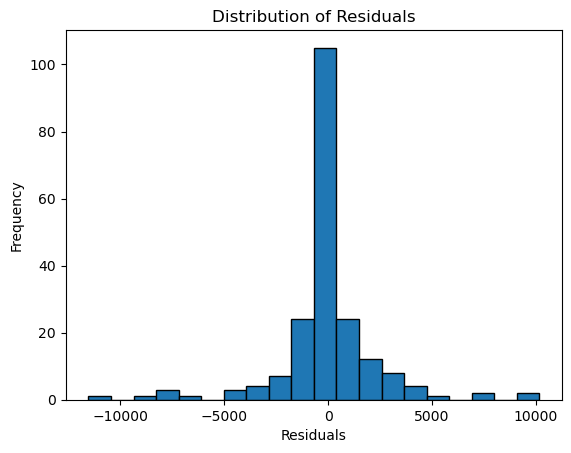

In [62]:
plt.hist(residuals, bins=20, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

The scatter of residuals indicates that they do not follow any pattern and their concentration around zero, as seen in the histogram, suggests that the model's predictions are not biased. This pattern of evenly distributed residuals suggests the errors are normally distributed, as well as the model reliably predicts the dependent variable based on the independent variables.

### 2. Peak Energy Consumption during Summer and Winter (Used KMeans Clustering)

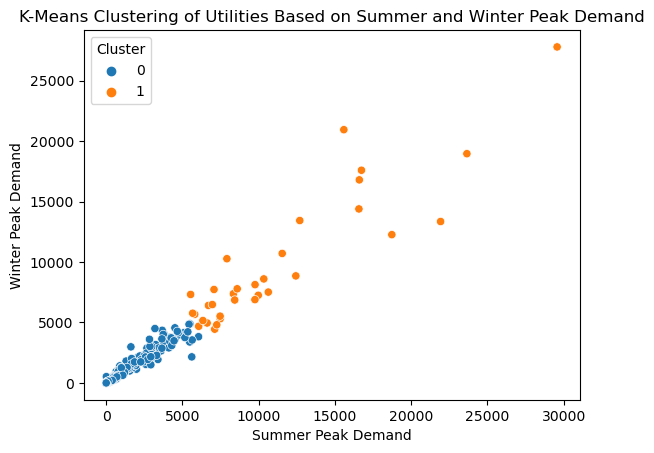

Cluster centroids (standardized): [[-0.08278839 -0.08201987]
 [ 7.87744039  7.80431523]]
Cluster centroids (original scale): [[  154.65713376   136.26124204]
 [11086.48787879  9698.97878788]]


In [63]:
# Feature selection
features = data[['Demand.Summer Peak', 'Demand.Winter Peak']].dropna()

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# K-Means clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_features)

# Add the cluster assignments back to the original data
data['Cluster'] = clusters

# Visualize the clusters
sns.scatterplot(x='Demand.Summer Peak', y='Demand.Winter Peak', hue='Cluster', data=data)
plt.title('K-Means Clustering of Utilities Based on Summer and Winter Peak Demand')
plt.xlabel('Summer Peak Demand')
plt.ylabel('Winter Peak Demand')
plt.show()

# Analyze the centroids to infer climate patterns
centroids = kmeans.cluster_centers_
print('Cluster centroids (standardized):', centroids)

# Reverse the scaling to interpret the centroids in the original scale
original_centroids = scaler.inverse_transform(centroids)
print('Cluster centroids (original scale):', original_centroids)


The centroids of the clusters in the original scale (which represent the average summer and winter peak demands for the clusters) show significant differences between the two clusters:

Cluster 0 (Blue): This cluster has lower average summer and winter peak demands.
Cluster 1 (Orange): This cluster has higher average summer and winter peak demands.

#### Perfom t-test to compare energy consumption between two custers identified in K-means clustering process above

In [64]:
# Feature selection
features = data[['Demand.Summer Peak', 'Demand.Winter Peak']].dropna()

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# K-Means clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_features)

# Add the cluster assignments back to the original data
data['Cluster'] = clusters

# Separate data for each cluster
consumption_cluster0 = data[data['Cluster'] == 0]['Demand.Summer Peak']
consumption_cluster1 = data[data['Cluster'] == 1]['Demand.Summer Peak']

# Perform a t-test
t_stat, p_value = stats.ttest_ind(consumption_cluster0, consumption_cluster1)

print('t-statistic:', t_stat)
print('p-value:', format(p_value, '.10f'))

# Evaluate the result
alpha = 0.05  
if p_value < alpha:
    print("Reject the null hypothesis - there is a significant difference in energy consumption between the clusters.")
else:
    print("Fail to reject the null hypothesis - there is no significant difference in energy consumption between the clusters.")


t-statistic: -77.10561268961945
p-value: 0.0000000000
Reject the null hypothesis - there is a significant difference in energy consumption between the clusters.


1. The t-statistic is a measure of the difference between the two clusters in terms of their mean energy consumption relative to the variation observed within each cluster.A very large absolute value of the t-statistic indicates that the two clusters are significantly different from each other.

2. The p-value is very low (reported as 0.0 due to rounding in the output), which suggests that the difference in mean energy consumption between the two clusters is statistically significant. 

3. Since the p-value is less than the typical alpha level of 0.05, the null hypothesis (that there is no difference in mean energy consumption between the clusters) is rejected. This suggests that the two clusters do indeed have different average energy consumptions.

4. Implications for Business Strategy:
The significant difference in energy consumption between the clusters could have implications for energy management strategies. It indicates that different utilities (or groups of utilities) may require tailored approaches to energy planning and demand management,reflective of their distinct consumption patterns.

### 3. What Drives Differences in Revenue Across Customer Segments?(Used KMeans Clustering)

0    3116
1      49
2       8
Name: RevenueCluster, dtype: int64
                Retail.Residential.Revenue  Retail.Commercial.Revenue  \
RevenueCluster                                                          
0                             2.828199e+04               1.954093e+04   
1                             1.384635e+06               1.092809e+06   
2                             3.826033e+06               4.342210e+06   

                Retail.Industrial.Revenue  
RevenueCluster                             
0                            10777.539409  
1                           424022.855102  
2                           999002.462500  


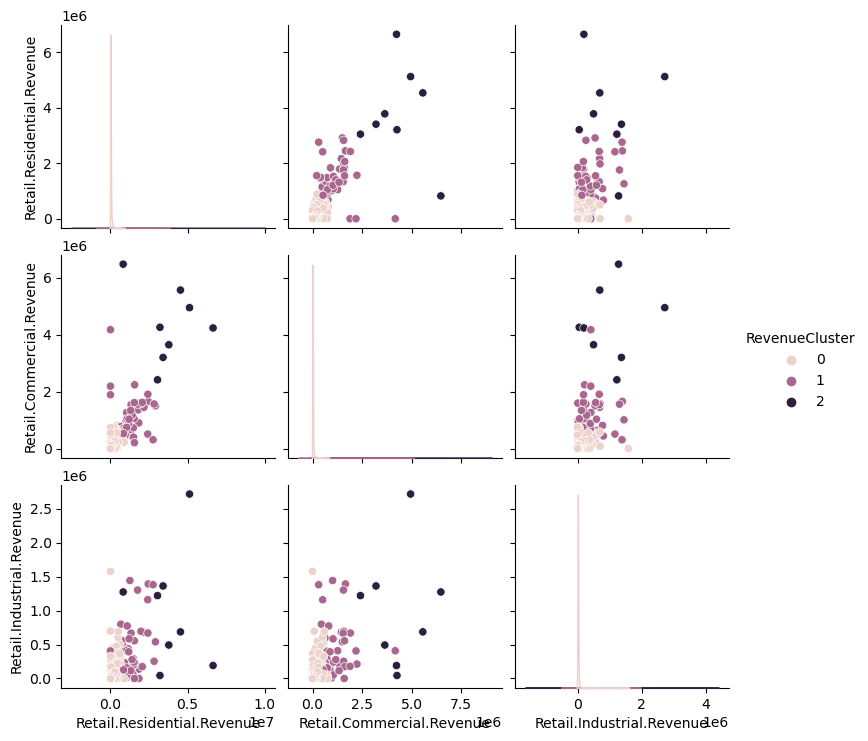

In [65]:
# Select the relevant features for clustering
features = data[['Retail.Residential.Revenue', 'Retail.Commercial.Revenue', 'Retail.Industrial.Revenue']]

# Apply KMeans clustering for 3 clusters
kmeans = KMeans(n_clusters=3, n_init=10, random_state=0)  # Add random_state for reproducibility
clusters = kmeans.fit_predict(features)

# Add the cluster assignments to the DataFrame
data['RevenueCluster'] = clusters

# Count the number of utilities in each cluster
print(data['RevenueCluster'].value_counts())

# Calculate the mean revenue for each cluster
cluster_means = data.groupby('RevenueCluster')[['Retail.Residential.Revenue', 'Retail.Commercial.Revenue', 'Retail.Industrial.Revenue']].mean()
print(cluster_means)

# Visualize the result
sns.pairplot(data, vars=['Retail.Residential.Revenue', 'Retail.Commercial.Revenue', 'Retail.Industrial.Revenue'], hue='RevenueCluster')
plt.show()



There are three clusters identified, with Cluster 0 having the majority of utilities (3117), followed by Cluster 1 with 49, and Cluster 2 with 8. 
This suggests that most utilities have similar revenue characteristics, with a few outliers showing distinctly different patterns.

Revenue Characteristics:

1. Cluster 0 shows lower average revenue across all segments, which could indicate smaller utilities or those operating in regions with lower energy consumption or lower rates.
2. Cluster 1 has much higher average commercial and industrial revenues compared to residential revenue. This suggests these utilities might be serving areas with significant commercial and industrial activities.
3. Cluster 2 has exceptionally high industrial revenue, which implies these utilities are likely servicing large industrial customers, possibly in areas with heavy industry or manufacturing.

Implications for Business Strategy:

1. Utilities in Cluster 1 might focus on maintaining and expanding commercial and industrial relationships, as these segments are significant revenue drivers.
2. Utilities in Cluster 2 may need to prioritize industrial sector needs, possibly focusing on high-capacity infrastructure and reliability to support large-scale industrial operations.
3. Cluster 0 utilities may look into strategies for growth or diversification if they wish to increase their revenue, as they represent the lower end of the revenue spectrum.

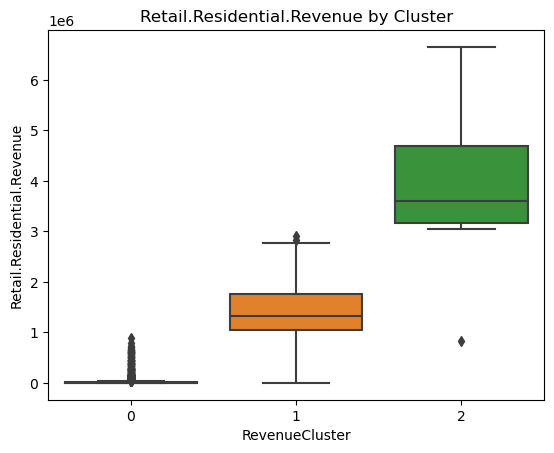

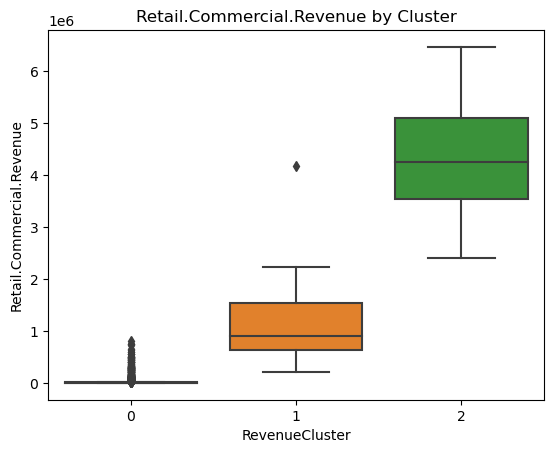

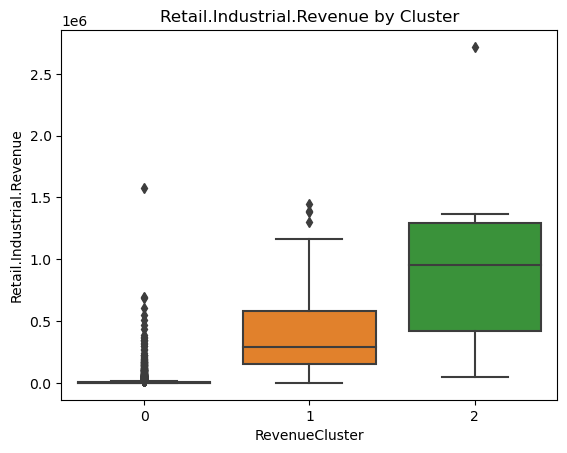

ANOVA for Retail.Residential.Revenue:
F-Statistic: 5177.742100995539
P-Value: 0.0
Statistically significant differences detected.
ANOVA for Retail.Commercial.Revenue:
F-Statistic: 6777.924527483677
P-Value: 0.0
Statistically significant differences detected.
ANOVA for Retail.Industrial.Revenue:
F-Statistic: 1289.9861151388823
P-Value: 0.0
Statistically significant differences detected.


In [66]:

# Define the relevant features and the cluster column
features = ['Retail.Residential.Revenue', 'Retail.Commercial.Revenue', 'Retail.Industrial.Revenue']
cluster_column = 'RevenueCluster'

# Create a boxplot to visualize revenue differences across clusters
for feature in features:
    sns.boxplot(x=cluster_column, y=feature, data=data)
    plt.title(f'{feature} by Cluster')
    plt.show()

# Perform ANOVA to test for statistical significance of revenue differences between clusters
for feature in features:
    grouped_data = [data[data[cluster_column] == cluster][feature] for cluster in range(3)]
    f_statistic, p_value = stats.f_oneway(*grouped_data)
    print(f"ANOVA for {feature}:")
    print(f"F-Statistic: {f_statistic}")
    print(f"P-Value: {p_value}")
    if p_value < 0.05:  # You can adjust the significance level as needed (e.g., 0.05)
        print("Statistically significant differences detected.")
    else:
        print("No statistically significant differences detected.")
    print("=" * 40)

1. Statistical Significance: In all three cases (Retail.Residential.Revenue, Retail.Commercial.Revenue, and Retail.Industrial.Revenue), the p-values are reported as 0.0, which means that there is strong evidence to reject the null hypothesis. This indicates that there are significant differences in revenue among the groups being compared.

2. Revenue Differences Exist: The F-statistics are quite high for all three categories, indicating substantial variability in revenue across the different groups within each category. This suggests that the revenue generated in the retail sector significantly varies across different segments.

3. Segment Differentiation: The ANOVA tests have identified that there are significant differences in revenue among various segments within the retail sector, such as residential, commercial, and industrial. This could imply that each of these segments has unique characteristics or market dynamics that impact their revenue generation.


4. Business Implication Possible:

i)Pricing Strategies: Tailor pricing structures by creating pricing plans that cater to the specific needs and consumption patterns of residential and commercial customers. Residential customers may prefer stable, predictable pricing, while commercial customers may be more interested in flexible pricing options.

ii)Energy Efficiency Programs: Offer energy efficiency incentives for segment customers to adopt energy-efficient technologies and practices. This can help reduce energy consumption and costs for both segments.

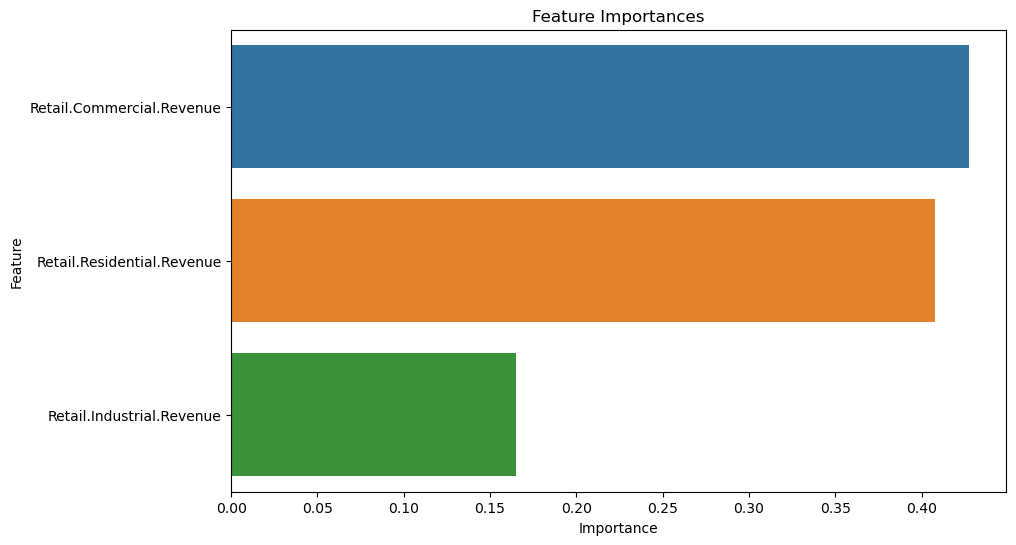

                      Feature  Importance
1   Retail.Commercial.Revenue    0.427554
0  Retail.Residential.Revenue    0.407595
2   Retail.Industrial.Revenue    0.164852


In [67]:
# Separate the features and the target variable (RevenueCluster)
X = data[['Retail.Residential.Revenue', 'Retail.Commercial.Revenue', 'Retail.Industrial.Revenue']]
y = data['RevenueCluster']

# Fit a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=0)
rf_classifier.fit(X, y)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

# print the importance values
print(importance_df)

1. Retail.Commercial.Revenue has the highest importance score of approximately 0.427, suggesting that commercial revenue plays the most significant role in predicting the RevenueCluster among the three features examined.

2. Retail.Residential.Revenue is the second most important feature with a score of about 0.407, indicating it also has a substantial impact on the prediction of RevenueCluster.

3. Retail.Industrial.Revenue has the lowest importance score of approximately 0.165, which means it has less predictive power compared to the other two features when determining the RevenueCluster.

4. The importance of these features could be used to inform business strategies, such as focusing on factors that drive commercial and residential revenue since they are most indicative of the RevenueCluster class, which could be related to different customer segments or revenue tiers.

In [68]:
# Define the features for clustering
features = data[['Retail.Residential.Revenue', 'Retail.Commercial.Revenue', 'Retail.Industrial.Revenue']]

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, n_init=10)  # Example with 3 clusters
clusters = kmeans.fit_predict(features)

# The inertia (Within-Cluster Sum of Squares)
inertia = kmeans.inertia_
print("Inertia (Within-Cluster Sum of Squares):", inertia)

Inertia (Within-Cluster Sum of Squares): 129180556016452.02


In [69]:
# Normalize the feature data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply KMeans clustering to the scaled data
kmeans_scaled = KMeans(n_clusters=3, n_init=10)
clusters_scaled = kmeans_scaled.fit_predict(features_scaled)

# The inertia of the scaled data
inertia_scaled = kmeans_scaled.inertia_
print("Inertia of Scaled Data (Within-Cluster Sum of Squares):", inertia_scaled)

Inertia of Scaled Data (Within-Cluster Sum of Squares): 2902.7008712576735


1. Before Normalization: The initial run of KMeans clustering on the data without normalization resulted in an inertia (within-cluster sum of squares) of 129180556016452.0. A high inertia value, such as this one, could indicate that the clusters are not very tight and may be spread out.

2. After Normalization: The data was then normalized using StandardScaler, which scales the features to have a mean of 0 and a standard deviation of 1, making the variance of the features similar. After normalization, the inertia drastically reduced to 2902.7008712576735. This significant reduction suggests that scaling the features improved the clustering by making the algorithm less sensitive to the scale of the features and thus able to find a better partition of the data into clusters.

##### Total revenue by customer segment: residential, commercial, and industrial.

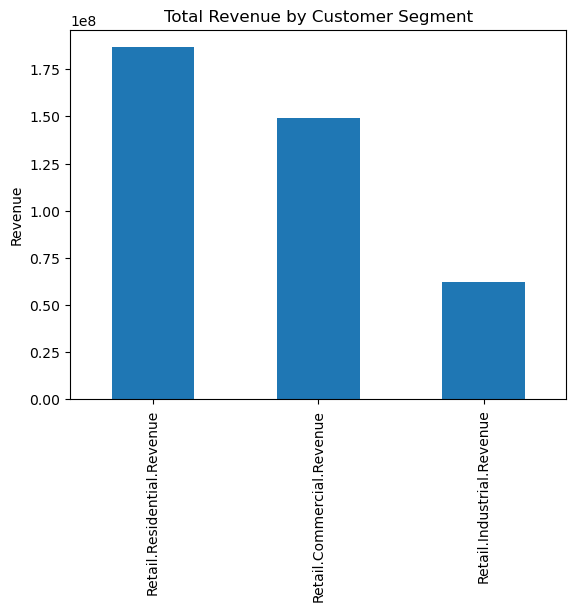

In [70]:
segments = ['Retail.Residential.Revenue', 'Retail.Commercial.Revenue', 'Retail.Industrial.Revenue']
data[segments].sum().plot(kind='bar')
plt.title('Total Revenue by Customer Segment')
plt.ylabel('Revenue')
plt.show()


1. The residential segment contributes the most to the total revenue, followed by the commercial and then the industrial segment.This could indicate that the residential sector is the largest or most lucrative market for the utilities represented in the dataset.


2. Given the high revenue from residential customers, utilities might find it beneficial to invest in energy efficiency programs targeted at this segment,potentially leading to cost savings for both the utility and the customer.


3. The data may also inform demand-side management strategies, such as encouraging peak load reduction in the residential segment to manage the utility's load profile more effectively.


##### Plotting Energy Sources and Energy Uses

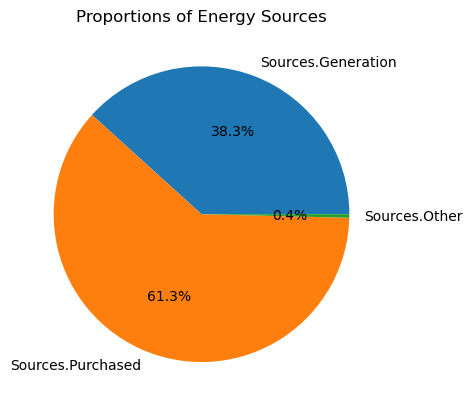

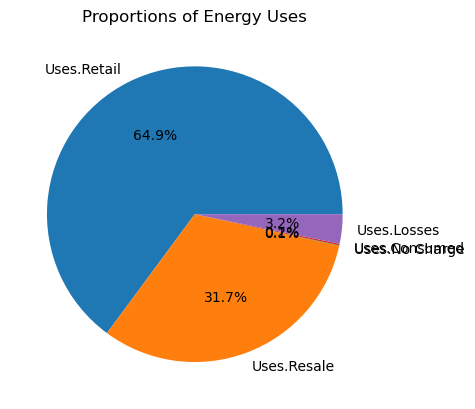

In [71]:
# energy sources
sources = ['Sources.Generation', 'Sources.Purchased', 'Sources.Other']
data[sources].sum().plot(kind='pie', autopct='%1.1f%%')
plt.title('Proportions of Energy Sources')
plt.ylabel('') 
plt.show()

# energy uses

uses = ['Uses.Retail', 'Uses.Resale', 'Uses.No Charge', 'Uses.Consumed', 'Uses.Losses']
data[uses].sum().plot(kind='pie', autopct='%1.1f%%')
plt.title('Proportions of Energy Uses')
plt.ylabel('') 
plt.show()


## Conclusion

Our analysis began with meticulous data cleaning, where we ensured the integrity of our dataset by checking for and handling missing values, removing outliers, and calculating summary statistics.The dataset was confirmed to be robust and free of null values, with outliers managed through the Interquartile Range (IQR) method. This provided a solid foundation for the subsequent exploratory and predictive analyses.

During the exploratory data analysis, we conducted visualizations to identify outliers using box plots for significant attributes and evaluated key variables' correlations. These visualizations revealed patterns and relationships within the data, allowing for a more nuanced understanding of the underlying structure of our variables.

The predictive analysis and modeling were divided into three key inquiries:

i) Peak Energy Demand's Impact on Total Utility Revenue: Through linear regression, we found that increases in energy usage during peak times are proportionally associated with increases in revenue. This insight is crucial for utility companies for capacity planning, pricing models, and demand response programs, potentially informing dynamic pricing strategies and financial forecasting.

ii) Peak Energy Consumption during Summer and Winter: KMeans clustering was applied to understand seasonal demand patterns. The standardized centroids of clusters showed significant differences in summer and winter peak demands, indicating distinct consumption patterns that could inform tailored energy management strategies for different utility groups.

iii) Drivers of Revenue Differences Across Customer Segments: Further clustering revealed clear segments within the utilities based on residential, commercial, and industrial revenues. Significant variances in revenue generation suggest that different utilities or utility groups may require tailored approaches to energy planning and demand management reflective of their distinct consumption patterns.

The results underscore the importance of effective demand management and the potential financial benefits of ensuring the utility has sufficient capacity to meet peak demands. For residential segments contributing most to the total revenue, investing in energy efficiency programs could lead to cost savings for both the utility and customers.